In [2]:
!pip install transformers
!pip install nltk
!pip install tqdm
!pip install faiss-cpu sentence-transformers
!pip install openai
!pip install google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [3]:
import os
import openai
import google.generativeai as genai
import json
import numpy as np
import pandas as pd
import torch
import nltk
import faiss
import re
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_DIR = "/content/drive/My Drive/BDS_Topic_Clustering/final_jsons"
OUTPUT_DIR = "/content/drive/My Drive/BDS_Topic_Clustering/output_embeddings"

Link to All folders - https://drive.google.com/drive/folders/19jKtMboy7-_yJW4cfWFLAUzrvt-xJRzy?usp=sharing

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
bert_model_name = "bert-base-uncased"

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertModel.from_pretrained(bert_model_name)
model.eval()  # Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# **1. Load JSON files and extract text**

In [8]:
def load_json_files(data_dir):
    #Load JSON files and extract relevant text fields, handling missing values.
    all_texts = []
    file_ids = []

    for file in os.listdir(data_dir):
        if file.endswith(".json"):
            file_path = os.path.join(data_dir, file)
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            # Extract text, handle missing values
            title = data["metadata"].get("title", "") or ""
            abstract = " ".join([para.get("text", "") for para in data["metadata"].get("abstract", []) if para.get("text")])
            body_text = " ".join([para.get("text", "") for para in data["metadata"].get("body_text", []) if para.get("text")])

            # Combine all extracted text
            combined_text = f"{title} {abstract} {body_text}".strip()

            if combined_text:  # Ensure non-empty entries
                file_ids.append(file.split(".json")[0])
                all_texts.append(combined_text)

    return file_ids, all_texts

# **2. Preprocess Text**

In [9]:
def preprocess_text(text):
    #Lowercase, tokenize, remove stopwords, and lemmatize.
    words = word_tokenize(text.lower())  # Lowercasing & tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return " ".join(words)

# **3. Generate TF-IDF Embeddings**

In [10]:
def generate_tfidf_embeddings(texts):
    #Compute TF-IDF embeddings.
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix.toarray(), vectorizer

# **4. Generate BERT Embeddings**

In [11]:
def generate_bert_embeddings(texts):
    #Compute BERT embeddings (average over token embeddings).
    embeddings = []

    for text in tqdm(texts, desc="Generating BERT embeddings"):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_length, hidden_dim)
        sentence_embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Mean pooling
        embeddings.append(sentence_embedding)

    return np.array(embeddings)

# **5. Save embeddings**

In [12]:
def save_embeddings(file_ids, tfidf_embeddings, bert_embeddings):
    #Save embeddings as .npy files and CSV summaries.
    np.save(os.path.join(OUTPUT_DIR, "tfidf_embeddings.npy"), tfidf_embeddings)
    np.save(os.path.join(OUTPUT_DIR, "bert_embeddings.npy"), bert_embeddings)

    # Save file mappings for reference
    df = pd.DataFrame({"file_id": file_ids})
    df.to_csv(os.path.join(OUTPUT_DIR, "file_mappings.csv"), index=False)

    print("Embeddings saved successfully!")

# **6. Run the pipeline**

In [13]:
print("Loading JSON files...")
file_ids, raw_texts = load_json_files(DATA_DIR)

print("Preprocessing text...")
processed_texts = [preprocess_text(text) for text in tqdm(raw_texts, desc="Preprocessing")]

print("Generating TF-IDF embeddings...")
tfidf_embeddings, vectorizer = generate_tfidf_embeddings(processed_texts)

print("Generating BERT embeddings...")
bert_embeddings = generate_bert_embeddings(processed_texts)

print("Saving embeddings...")
save_embeddings(file_ids, tfidf_embeddings, bert_embeddings)

print("All done!")

Loading JSON files...
Preprocessing text...


Preprocessing: 100%|██████████| 79/79 [00:07<00:00,  9.92it/s]


Generating TF-IDF embeddings...
Generating BERT embeddings...


Generating BERT embeddings: 100%|██████████| 79/79 [02:37<00:00,  1.99s/it]


Saving embeddings...
Embeddings saved successfully!
All done!


# **7. Checking shapes of the embeddings (to ensure all files were processed)**

In [14]:
# Load file mappings
df = pd.read_csv("/content/drive/My Drive/BDS_Topic_Clustering/output_embeddings/file_mappings.csv")

# Load embeddings
bert_embeddings = np.load("/content/drive/My Drive/BDS_Topic_Clustering/output_embeddings/bert_embeddings.npy")
tfidf_embeddings = np.load("/content/drive/My Drive/BDS_Topic_Clustering/output_embeddings/tfidf_embeddings.npy")

# Check counts
print(f"Number of JSONs processed: {len(df)}")
print(f"BERT Embeddings Shape: {bert_embeddings.shape}")
print(f"TF-IDF Embeddings Shape: {tfidf_embeddings.shape}")

Number of JSONs processed: 79
BERT Embeddings Shape: (79, 768)
TF-IDF Embeddings Shape: (79, 5000)


# **8. Dimensionality Reduction using PCA and t-SNE**

BERT Embeddings Shape: (79, 768)
TF-IDF Embeddings Shape: (79, 5000)
Applying PCA on TF-IDF embeddings...
Explained variance ratio: [0.03873958 0.03232066]
Applying PCA on BERT embeddings...
Explained variance ratio: [0.19366682 0.09825846]
Applying t-SNE on TF-IDF embeddings...
Applying t-SNE on BERT embeddings...


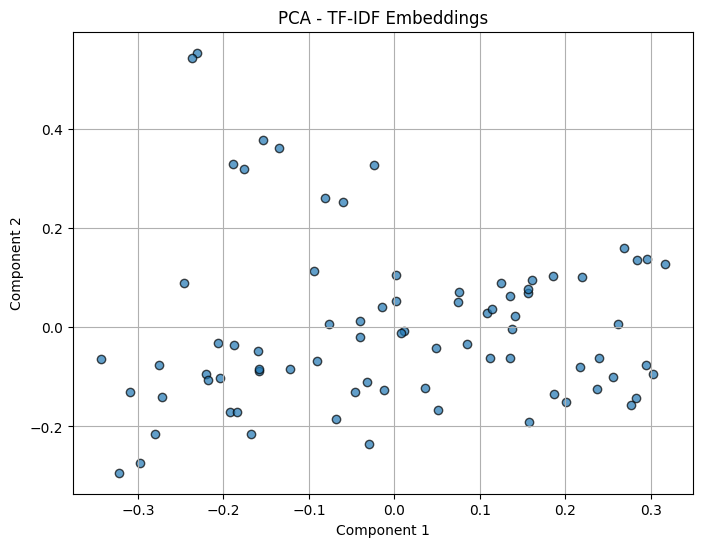

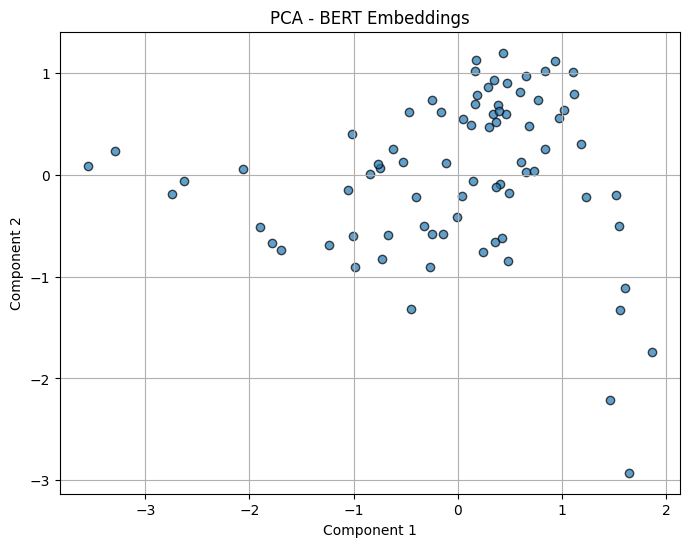

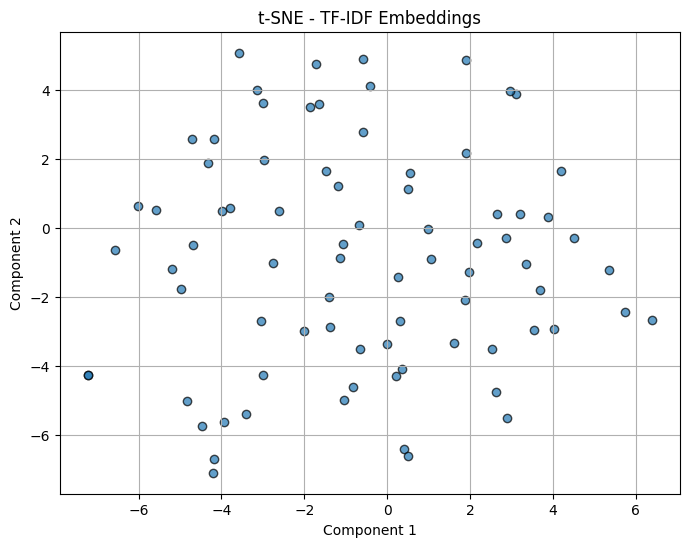

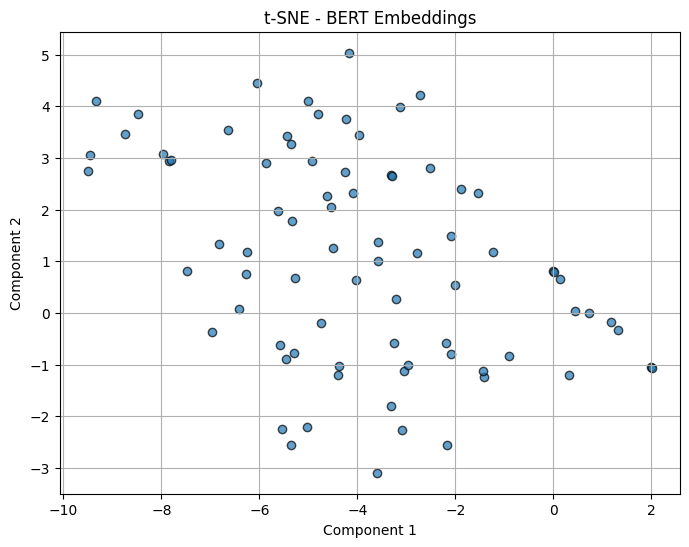

PCA and t-SNE visualizations saved in output directory.


In [15]:
bert_embeddings = np.load(os.path.join(OUTPUT_DIR, "bert_embeddings.npy"))
tfidf_embeddings = np.load(os.path.join(OUTPUT_DIR, "tfidf_embeddings.npy"))

print(f"BERT Embeddings Shape: {bert_embeddings.shape}")
print(f"TF-IDF Embeddings Shape: {tfidf_embeddings.shape}")

# PCA Reduction
def apply_pca(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return reduced_embeddings

# t-SNE Reduction
def apply_tsne(embeddings, n_components=2, perplexity=30, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

# Visualization
def plot_embeddings(embeddings, title, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.7, edgecolors="k")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.show()

print("Applying PCA on TF-IDF embeddings...")
tfidf_pca = apply_pca(tfidf_embeddings)
print("Applying PCA on BERT embeddings...")
bert_pca = apply_pca(bert_embeddings)

print("Applying t-SNE on TF-IDF embeddings...")
tfidf_tsne = apply_tsne(tfidf_embeddings)
print("Applying t-SNE on BERT embeddings...")
bert_tsne = apply_tsne(bert_embeddings)


plot_embeddings(tfidf_pca, "PCA - TF-IDF Embeddings", "PCA_TFIDF.png")
plot_embeddings(bert_pca, "PCA - BERT Embeddings", "PCA_BERT.png")

plot_embeddings(tfidf_tsne, "t-SNE - TF-IDF Embeddings", "tSNE_TFIDF.png")
plot_embeddings(bert_tsne, "t-SNE - BERT Embeddings", "tSNE_BERT.png")

print("PCA and t-SNE visualizations saved in output directory.")

# **9. Class-based TF-IDF and Topic Extraction**

In [16]:
tfidf_embeddings = np.load(os.path.join(OUTPUT_DIR, "tfidf_embeddings.npy"))
df_files = pd.read_csv(os.path.join(OUTPUT_DIR, "file_mappings.csv"))  # File mappings

print(f"TF-IDF Embeddings Shape: {tfidf_embeddings.shape}")
print(f"Number of documents: {len(df_files)}")

# Cluster Using K-Means
NUM_CLUSTERS = 5
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
df_files["cluster"] = kmeans.fit_predict(tfidf_embeddings)

# Load JSONs and Extract Texts (Titles & Abstracts)
def load_texts(data_dir):
    texts = {}
    doc_titles = {}
    for file in os.listdir(data_dir):
        if file.endswith(".json"):
            file_id = file.replace(".json", "")  # Ensure file ID is a string
            with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
                data = json.load(f)
            title = data["metadata"].get("title", "") or "Untitled Document"
            abstract = " ".join([para.get("text", "") for para in data["metadata"].get("abstract", []) if para.get("text")])
            body_text = " ".join([para.get("text", "") for para in data["metadata"].get("body_text", []) if para.get("text")])
            texts[file_id] = f"{title} {abstract} {body_text}".strip()
            doc_titles[file_id] = f"{title} - {abstract[:200]}..."
    return texts, doc_titles

print("Loading document texts...")
doc_texts, doc_titles = load_texts(DATA_DIR)

# Convert file_id in df_files to string
df_files["file_id"] = df_files["file_id"].astype(str)

# Merge texts within each cluster, ensuring no empty entries
cluster_texts = []
for i in range(NUM_CLUSTERS):
    texts_in_cluster = [doc_texts[file_id] for file_id in df_files[df_files["cluster"] == i]["file_id"] if file_id in doc_texts]
    merged_text = " ".join(texts_in_cluster).strip()

    # Apply preprocessing to remove stopwords from cluster text
    if merged_text:
        cluster_texts.append(preprocess_text(merged_text))
    else:
        cluster_texts.append("empty cluster")

# Compute TF-IDF for clusters
vectorizer = TfidfVectorizer(max_features=1000)
cluster_tfidf = vectorizer.fit_transform(cluster_texts)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Extract Top 6 Keywords Per Cluster
print("Extracting top keywords...")
top_keywords = {}
for i in range(NUM_CLUSTERS):
    sorted_indices = cluster_tfidf[i].toarray().argsort()[0][-6:][::-1]  # Get top 6 keywords
    top_keywords[i] = [feature_names[idx] for idx in sorted_indices]

# Find Representative Documents (Titles & Abstracts)
print("Finding representative documents...")
rep_docs = {}
for i in range(NUM_CLUSTERS):
    cluster_indices = df_files[df_files["cluster"] == i].index
    cluster_embeddings = tfidf_embeddings[cluster_indices]
    centroid = kmeans.cluster_centers_[i].reshape(1, -1)

    # Compute distances to centroid
    distances = euclidean_distances(cluster_embeddings, centroid).flatten()

    # Get indices of top 3 closest documents
    top_doc_indices = cluster_indices[np.argsort(distances)[:3]]
    rep_docs[i] = [doc_titles[df_files.loc[idx, "file_id"]] for idx in top_doc_indices]

# Results
print("\n**Cluster Summary**")
for cluster_id in range(NUM_CLUSTERS):
    print(f"\n Cluster {cluster_id}:")
    print("Representative Documents:")
    for doc in rep_docs[cluster_id]:
        print(f"   - {doc}\n")
    print(f"Top Keywords: {', '.join(top_keywords[cluster_id])}")

# Save results to CSV
df_summary = pd.DataFrame({
    "Cluster": list(range(NUM_CLUSTERS)),
    "Representative Documents": ["\n".join(rep_docs[i]) for i in range(NUM_CLUSTERS)],
    "Top Keywords": [", ".join(top_keywords[i]) for i in range(NUM_CLUSTERS)]
})
df_summary.to_csv(os.path.join(OUTPUT_DIR, "cluster_summary.csv"), index=False)

print("\nCluster summary saved as cluster_summary.csv")

TF-IDF Embeddings Shape: (79, 5000)
Number of documents: 79
Loading document texts...
Extracting top keywords...
Finding representative documents...

**Cluster Summary**

 Cluster 0:
Representative Documents:
   - Search for Multibody Nuclear Reactions in Metal Deuteride Induced with Ion Beam and Electrolysis Methods - We report here the experimental results suggesting the occurrence of multibody nuclear reactions in metal deuterides under ion-beam irradiation and electrolysis. A meaningful increase of
helium-4 was ...

   - PRODUCTION OF HIGH ENERGY CHARGED PARTICLES DURING DEUTERON IMPLANTATION OF TITANIUM DEUTERIDES - Implantation experiments using 300-keV deuteron beams are performed to study the 3-body reaction in metal deuterides with full use of in situ analyses of the target. The AE-E telescope and the angular...

Top Keywords: reaction, mev, spectrum, energy, target, deuteron

 Cluster 1:
Representative Documents:
   - PROGRESS TOWARDS REPLICATION - ...

   - Input to Theory f

# **10. Improving Topic Representations using Gemini**

In [17]:
OUTPUT_DIR = "/content/drive/My Drive/BDS_Topic_Clustering/output_embeddings"
SUMMARY_FILE = os.path.join(OUTPUT_DIR, "cluster_summary.csv")

# Load existing cluster summaries
df_summary = pd.read_csv(SUMMARY_FILE)

GEMINI_API_KEY = "your_key"
genai.configure(api_key=GEMINI_API_KEY)

gemini_model = genai.GenerativeModel("gemini-1.5-pro")

def generate_topic_description_gemini(keywords, representative_docs):

    prompt = (
        f"Given the following information about documents (research papers) in a cluster:\n"
        f"Keywords: {', '.join(keywords)}\n"
        f"Representative Documents: {representative_docs}\n"
        f"Please provide a meaningful and concise topic description for this cluster."
    )

    try:
        response = gemini_model.generate_content(prompt)

        # Extract the response
        topic_description = response.text.strip()
        return topic_description

    except Exception as e:
        print(f"Error generating topic for: {keywords} → {e}")
        return "Error generating topic"

# Generate & Save Refined Topics
for index, row in df_summary.iterrows():
    refined_topic = generate_topic_description_gemini(row["Top Keywords"].split(", "), row["Representative Documents"])

    print(f"\n Cluster {row['Cluster']}: {refined_topic}\n")

    df_summary.at[index, "Refined Topic"] = refined_topic

# Save updated results
df_summary.to_csv(os.path.join(OUTPUT_DIR, "refined_cluster_summary.csv"), index=False)

print("\n Refined topics saved as refined_cluster_summary.csv")


 Cluster 0: Deuteron-Induced Nuclear Reactions in Metal Deuterides


 Cluster 1: Cold Fusion/Low Energy Nuclear Reactions (LENR) in Palladium


 Cluster 2: Electrolytic Reactions in Aqueous Solutions


 Cluster 3: Cold Fusion in Metal Deuterides: Theoretical and Numerical Studies


 Cluster 4: Cold Fusion Controversy and Research


 Refined topics saved as refined_cluster_summary.csv


Input Prompt:

"Given the following information about documents (research papers) in a cluster:
        Keywords: {top 6 keywords}
        Representative Documents: {closest 3 representative docs},
Please provide a meaningful and concise topic description for this cluster."

Refined Topic Representations:

* Cluster 0: Deuteron-Induced Nuclear Reactions in Metal Deuterides
* Cluster 1: Cold Fusion/Low Energy Nuclear Reactions (LENR) in Palladium
* Cluster 2: Electrolytic Reactions in Aqueous Solutions
* Cluster 3: Cold Fusion in Metal Deuterides: Theoretical and Numerical Studies
* Cluster 4: Cold Fusion Controversy and Research

# **11. Question Answering with FAISS**

In [22]:
from sentence_transformers import SentenceTransformer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer

OUTPUT_DIR = "/content/drive/My Drive/BDS_Topic_Clustering/output_embeddings"
EMBEDDINGS_FILE = "bert_embeddings.npy"  # Can use TF-IDF too
MAPPINGS_FILE = "file_mappings.csv"

# Load document embeddings
doc_embeddings = np.load(f"{OUTPUT_DIR}/{EMBEDDINGS_FILE}")
df_mappings = pd.read_csv(f"{OUTPUT_DIR}/{MAPPINGS_FILE}")

print(f"Loaded {doc_embeddings.shape[0]} document embeddings.")

# Build FAISS Index
embed_dim = doc_embeddings.shape[1]  # Embedding dimension
index = faiss.IndexFlatL2(embed_dim)  # L2 (Euclidean) index
index.add(doc_embeddings)  # Add document embeddings to FAISS

print("FAISS index built.")

# Convert Questions to Embeddings
use_dpr = False  # Set to True to use DPR instead of SBERT

if use_dpr:
    tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
    model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
else:
    model = SentenceTransformer("bert-base-uncased")

def encode_query(query):
    if use_dpr:
        inputs = tokenizer(query, return_tensors="pt")
        with torch.no_grad():
            embedding = model(**inputs).pooler_output.numpy()
    else:
        embedding = model.encode([query])
    return embedding

def retrieve_documents(query, top_k=3):
    query_embedding = encode_query(query).astype("float32")

    # Search FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve document IDs and titles
    results = []
    for idx in indices[0]:
        file_id = df_mappings.iloc[idx]["file_id"]
        #title = df_mappings.iloc[idx]["title"] if "title" in df_mappings else f"Document {file_id}"

        results.append(f"{file_id}")

    return results

# Demonstrate QA System
example_queries = [
    "What are the latest advancements in LENR?",
    "What is the role of nuclear fusion in energy production?",
    "How does electrolysis contribute to hydrogen generation?"
]

for query in example_queries:
    print(f"\n Query: {query}")
    retrieved_docs = retrieve_documents(query)
    print(f" Retrieved Documents: {retrieved_docs}")

Loaded 79 document embeddings.
FAISS index built.



 Query: What are the latest advancements in LENR?
 Retrieved Documents: ['2072', '1816', '4402']

 Query: What is the role of nuclear fusion in energy production?
 Retrieved Documents: ['4239', '1816', '2072']

 Query: How does electrolysis contribute to hydrogen generation?
 Retrieved Documents: ['1816', '4402', '4239']
